# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (2da entrega)

## Fecha de entrega

*8/6/2021*

## Integrantes

* <Leandro, Di Meo>

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la función de ejemplo (`ruidoRosa_voss`)(1er entrega).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) completado y con las celdas ejecutas a myommi@untref.edu.ar.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import signal
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import signal
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt
import sounddevice as sd
import simpleaudio as sa
from IPython.display import Image
import soundfile as sf
import scipy



#Para funcion carga de archivos.
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display

## Descargar dataset
El objetivo es tener archivos para validar el software creado , para lo cual es necesario contar con la información y los datos de la medición.

### 1. Respuestas al impulso: 
**Consigna:** Descargar **al menos dos** respuestas al impulso (RI o en ingles IR, Impulse Responses) de dos recintos distintos del siguiente [link](https://www.openair.hosted.york.ac.uk/?page_id=36) y toda la información relevante de la medición, ademas de los resultados de los parametros acústicos calculados (para luego comparar). También se pueden usar los archivos dispuestos en el Drive de la asignatura. 

### 2. Sine sweep logarítmico + filtro inverso: 
**Consigna:** Descargar **al menos un** sine sweep con su respectivo filtro inverso. Una posibildiad es usar los archivos dispuestos en el GDrive de la asignatura. Para generar el filtro inverso usar la info brindada por el informe técnico en la misma carpeta de los archivos. 

## Función de carga de archivos de audio

**Consigna:** realizar una función que permita cargar archivos de audio, en lo posible \*.wav, por ejemplo los archivos anteriormente descargados. Contemplar el ingreso de más de un archivo de audio, por tipo.

In [3]:
def cargar_audio(paths):
    """
    In: Array con path de los archivos de audio.

    Out: Array con informacion de los archivos de audio, en sendos diccionarios.
    Los diccionarios tienen las keys las keys:
      

    Data: Contiene la codificacion de pulso modulado
    Bitdepth: Dtype del array data de audio.
    Subtype: Contiene la informacion de formato extraida con la libreria soundfile
    Duracion: La duracion en segundos del archivo de audio
      Samplerate: Frecuencia de sampleo obtenida con la libreria soundfile
      Nombre: El del objeto del cual se tomo la informacion. Se probo en wav.
      t: Linspace de largo igual a Duracion, con pasos de 1/(frecuencia de sampleo)

      Los diccionarios se crean en el orden que tenian los archivos en el array in. Se puede llamar el directorio de cada archivo como cargar_audio(pathfiles)[indice del archivo dentro del array]
    """
    audiodiccs=[]
    for path in paths:
        archivo=sf.SoundFile(path)
        data , fs = sf.read(path)
        subtype= "MAT5" if "DOUBLE"==archivo.subtype else "WAVE"
        frames=archivo.frames
        bitdepth=data.dtype
        audiodicc={"Nombre":None,"Samplerate":None, "Duracion":None,"Bitdepth":None,"Data":None, "t":None, "Subtype":None}
        audiodicc.update({"Nombre":path,"Samplerate":fs,"Bitdepth":bitdepth,"Duracion":frames/fs,"Subtype":subtype,"Data":data, "t":np.linspace(0,frames/fs,frames)})
        archivo.close()
        audiodiccs.append(audiodicc)
      
    return audiodiccs


Llamar a la función con uno de los ejemplos anteriormente descargados y usar la función de visualización de la 1er entrega.

In [7]:
def graficoaudio2(data,fs,t,archivo):
    """Permite plotear audio. 
    In: Data : en formato array
        fs   : frecuencia de sampleo.
        t    : Array de longitud igual a la duracion del audio, con igual cantidad de muestras que data, equiespaciadas linealmente.
    Return: Gráfica del  audio en funcion del tiempo"""
    # plot
    plt.plot(t,data, 'r')
    plt.title(archivo)
    plt.xlabel('Tiempo [s]') 
    plt.ylabel('Amplitud')
    plt.show()  


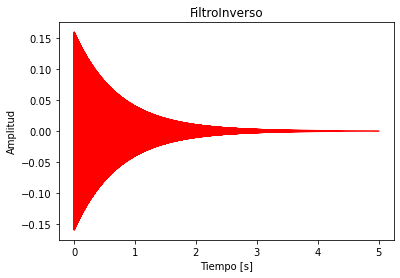

In [9]:
f_i="../Proyecto-python/audio/filtroinverso.wav"
ss="../Proyecto-python/audio/sinesweep.wav"
pathfiles=[ss,f_i]
AudiosPrueba=cargar_audio(pathfiles)
data=AudiosPrueba[1]["Data"]
fs=AudiosPrueba[1]["Samplerate"]
t= AudiosPrueba[1]["t"]

graficoaudio2(data , fs ,t,"FiltroInverso")
# plot

> **Opcional**: el código de la siguiente celda genera un botón de selección (ver los pasos de instalación [aqui](https://ipywidgets.readthedocs.io/en/latest/user_install.html)), y guarda las rutas a los archivos seleccionados en la variable files. La función desarrollada debería tomar las rutas y leer el contenido de los archivos, utilizando alguna de las librerías vistas en clase.

In [10]:
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display
files = []
def select_files(b,files=files):
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window.
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    files.append(filedialog.askopenfilename()) # List of selected files will be set button's file attribute.
    print(files) # Print the list of files selected.

fileselect = Button(description="Seleccione el archivo")
fileselect.on_click(select_files)

display(fileselect)
files

Button(description='Seleccione el archivo', style=ButtonStyle())

[]

## Función de sintetización de respuesta al impulso

**Consigna:** realizar una función para sintetizar una respuesta al impulso. La misma recibira como parametro el $T60$ que se desea obtener, y deberá sintetizar una respuesta al impulso considerando las frecuencias centrales de banda de octava y tercio de octava como establece la norma IEC61260 (IEC61260,1995). La siguiente ecuación define una RI, para una frecuencia central $f_{i}$:

\begin{equation}
y_{i}=A_{i}e^{π_{i}t}\cos(2πf_{i}t)
\tag{6}
\end{equation}

donde $A_{i}$ es el coeficiente de amplitud para esa $f_{i}$(puede ser 1), y  $π_{i}$ define el decaimiento exponencial en función de $T_{60}$ (tiempo de reverberación) para una frecuencia $f_{i}$.

\begin{equation}
π_{i}=\frac{T_{60}}{\ln(10^{-3})}
\tag{7}
\end{equation}

La suma de varias frecuencias centrales $f_{i}$ se define como:
\begin{equation}
  y=\sum_{y=1}^{n}y_{i}
\tag{8}
\end{equation}

Con $n$ la cantidad de frecuencias centrales $f_{i}$ del filtro. La funcion debe recibir el tiempo de reverberacion para cada frecuencia, y devolver la respuesta al impulso correspondiente como un archivo de audio .wav. Al momento de definir la función, buscar la forma de que la misma permita varios $T60$ para cada frecuencia. 

> Con esta funcion se busca obtener un archivo de audio de valores de $T60$ conocidos que permita probar el software.

In [14]:
def sintetizacion_ri(rt,amps,freqs,fs): 
    """
    Sintetiza una respuesta al impulso
    Parámetros de entrada:
        rt: array de tiempo de reverberacion por banda de frecuencias
        amps: moduladores de amplitud por 
        freqs: array con frecuencias utilizadas en Hz
    Salida:
        Array sintesis de respuesta al impulso y audio 
    Utiliza bibioteca de numpy
    """
    duracion=3*int(np.ceil(max(rt)))
    risub=np.zeros(duracion*fs,) #respuesta al impulso
    for i in np.arange(len(rt)):

        ri=lambda t: amps[i]*np.exp(t*rt[i]/np.log(10**-3))*np.cos(2*np.pi*freqs[i]*t)
        ritot=risub+ri(np.linspace(0,duracion,duracion*fs))
    filename = '../Proyecto-python/audio/sinte_ri.wav' #Nombre del archivo
    sd.wait()  #Esperar a que finalice la grabación
    write(filename, fs, ritot) #grabación   
    return ritot

In [13]:
def graficador(ys,nombre,ti,ejex,ejey):
    """Permite plotear funciones
    Parámetros de entrada:
     ys es la función, nombre es el nombre del grafico, ti es la coordenada independiente,
     ejex nombre del eje X y ejey nombre del eje Y.
    Return: Gráfica de la función de entrada con posibilidad de nombrar los ejes y darle un título"""
    fs = 44100
    x = (np.linspace (0, ti, fs*ti,False))
    # plot
    plt.plot(x,ys, 'r')
    plt.title(nombre)
    plt.xlabel(ejex) 
    plt.ylabel(ejey)
    plt.show()

Llamar a la función con un vector que contega varios $T60$ para las cada frecuencias centrales $f_{i}$.

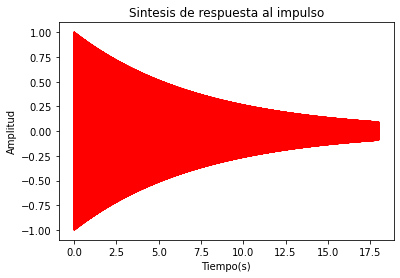

In [15]:
freqs = [31.25,62.5,125,250,500,1000,2000,4000,8000,16000]
rt= [5.68,4.41,3.86,2.86,2.59,2.61,2.47,2.02,1.32,0.92] #Obtenido de 1st_baptist_nashville_balcony"
amps = np.ones(10)
sinte=sintetizacion_ri(rt,amps,freqs,fs)
Tt=int(3*np.ceil(max(rt)))
graficador(sinte,"Sintesis de respuesta al impulso",Tt,"Tiempo(s)","Amplitud")


Reproducir señal resultante.

In [16]:
#Reproducir RI sinte
audio2 = sinte * (2**15 - 1) / np.max(np.abs(sinte)) #Defino y reproduzco la función
audio2 = audio2.astype(np.int16)
play_obj = sa.play_buffer(audio2, 1, 2, 44100)
play_obj.wait_done()

Comentar sobre el resultado obtenido, ¿Es una buena aproximación? ¿Qué aspectos estamos dejando de lado en esta sintetización, que en un caso real estan presentes?.

Solo se esta teniendo en cuenta los tiempos de reverberación, no se tienen en cuenta parametros de distorsión del sistema, las respuestas de los microfonos y parlantes que se utilizan, el piso de ruido, etc. 

## Función obtener respuesta al impulso

**Consigna:** realizar una función que permita obtener la respuesta al impulso en formato de señal de audio .wav, a partir del sinesweep logarítmico grabado y el filtro inverso generado utilizando el siguiente método: 

Supongamos que un recinto es excitado por una señal sinesweep logarítmica $x(t)$ y captada por un micrófono $y(t)$ y buscamos la RI del recinto $h(t)$, lo anterior se expresa de la siguiente manera:

\begin{equation}
y(t)=x(t)*h(t)
\tag{9}
\end{equation}

Para un sine sweep lineal (que no es nuestro caso) el problema es sencillo, pero en nuestro caso (sine sweep logarítmico) requiere trabajar un poco respecto $x(t)$ para obtener la siguiente expresión:

\begin{equation}
h(t) = F^{-1}[H(jw)]=F^{-1}[Y(jw)K(jw)]
\tag{10}
\end{equation}

Recordar que $k(t)$ es el filtro inverso (ecu.5) y $K(jw)$ su respectiva transformada de fourier. De esta manera se obtiene la respuesta al impulso buscada.

> El desarrollo matemático de la anterior expresión se encuentra en el [Anexo I - Obtener la respuesta al impulso a partir de un sine sweep](../consigna_TP_matlab.pdf) (p.14) del instructivo para Matlab del TP.

In [17]:
T = int(input("Ingrese el tiempo de reproducción:"))
fs = 44100
t = np.linspace(0., T, fs*T, False)
f1 = float(input("Ingrese frecuencia inferior:" ))
f2 = float(input("Ingrese frecuencia superior:" ))
def sinesweep (f1, f2, T,t) : #Función sinesweep
    '''La función sinesweep genera un barrido en frecuencias que decae 3dB/octava.
       Parametros de entrada: f1:Frecuencia incial del barrido.Formato Float.
                              f2:Frecuencia final del barrido.Formato Float.
                              T: Tiempo de duración.Formato Int.
                              t:variable temporal.Formato Array.
       Parametro de salida: f: representa la función del barrido.
       También exporta audio formato .wav de duración T segundos y frecuencia de muestreo fs, si el mismo ya existe, será sobreescrito. 
       Dicha función utiliza recursos de la librería numpy, importando la misma como import numpy as np.'''
    w1 = 2*np.pi*f1
    w2 = 2*np.pi*f2
    R = np.log(w2 / w1)
    L = T / R
    K = (T*w1)/R
    f = np.sin(K*(np.exp(t/L) - 1))
    filename = '../sinesweep.wav' #Nombre del archivo
    sd.wait()  #Esperar a que finalice la grabación
    write(filename, fs, f) #grabación
    return f

def filtroinverso (f1,f2,T,t): #Función filtro
    '''La función filtroinverso genera un filtro que aumenta 3dB/octava. 
       Parametros de entrada: f1:Frecuencia incial del barrido.Formato Float
                              f2:Frecuencia final del barrido.Formato Float
                              T: Tiempo de duración.Formato Int
                              t:variable temporal.Formato Array
       Parametro de salida: FI: representa la función de filtro inverso.
       También exporta audio formato .wav de duración T segundos y frecuencia de muestreo fs, si el mismo ya existe, será sobreescrito. 
       Dicha función utiliza recursos de la librería numpy, importando la misma como import numpy as np.'''
    w1 = 2*np.pi*f1
    w2 = 2*np.pi*f2
    R = np.log(w2 / w1)
    L = T / R
    K = (T*w1)/R
    W = (K/L)*np.exp(t/L)
    M = w1/(2*np.pi*W)
    FI = M*sinesweep(f1,f2,T,t[::-1])
    filename = '../filtroinverso.wav' #Nombre del archivo
    sd.wait()  #Esperar a que finalice la grabación
    write(filename, fs, FI) #grabación
    return FI
filtro_inv = filtroinverso(f1,f2,T,t)
sinesweep_audio = sinesweep(f1,f2,T,t)


Ingrese el tiempo de reproducción: 5
Ingrese frecuencia inferior: 20
Ingrese frecuencia superior: 20000


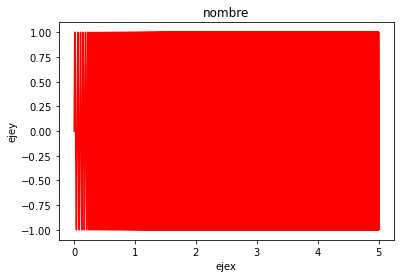

In [18]:
graficador(sinesweep_audio,'nombre',T,'ejex','ejey')

Llamar a la función con un sine sweep y su respectivo filtro inverso creados con la función de la primer entrega (**no** los descargados).

In [27]:

# Leyendo audio con scipy.io
#audioFileName = "../sinesweep.wav"
#fs, audiodata = wavfile.read(audioFileName)
#au = "../filtroinverso.wav"
#fs2, audiodata2 = wavfile.read(au)
def resp_imp (x, y):
    '''Función de obtención de la respuesta al impulso de un recinto
       Parametros de entrada:
       X:Impulso o excitación
       Y:Captación del impulso con la respuesta del recinto
       Mediante la transformada rapida de fourier de la biblioteca Scipy, 
       Return: Respuesta al impulso de la sala'''

    Y = scipy.fft.fft(y)
    X = scipy.fft.fft(x)
    H = Y/X
    w = scipy.signal.windows.cosine(len(x), sym=True)
    h = scipy.fft.ifft(H)*w
    #resp = "../respuesta_impulso"
    #write(resp, fs, h)
    return h


In [30]:

resp_impulso = resp_imp(sinesweep_audio,filtro_inv)



Visualizar la señal con la función creada en la primer entrega.

C:\Users\LeaDm\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


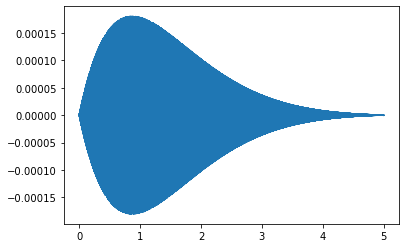

In [31]:
plt.plot(t,resp_impulso)

Reproducir señal resultante.

In [32]:
audio2 = resp_impulso * (2**15 - 1) / np.max(np.abs(resp_impulso)) #Defino y reproduzco la función
audio2 = audio2.astype(np.int16)
play_obj = sa.play_buffer(audio2, 1, 2, 44100)
play_obj.wait_done()

<ipython-input-32-7834b93de846>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  audio2 = audio2.astype(np.int16)


Comentar sobre el resultado obtenido. ¿Qué es lo que se esta escuchando? Realizar el mismo procedimiento con la señal descargada y el filtro inverso generado (para dicho sine sweep)

No se logro ejecutar, en principio creemos que se debe escuchar la respuesta al impulso de la sala 

Mencionar aspectos que diferencian los impulso generados en esta función, con los sintetizados.

*completar*

## Función filtros norma IEC61260

**Consigna**:Realizar una función que filtre todas las señales en octavas y tercio de octava según la norma IEC61260, con el objetivo de calcular los parámetros acústicos discriminando las frecuencias. 

Para lo cual utilizar las funciones del modulo [signals de scipy](https://docs.scipy.org/doc/scipy/reference/signal.html). Se adjunta el código capaz de calcular los coeficientes del filtro y aplicarlos a una señal. La función debe completarse con el código necesario para que este proceso se repita para cada una de las frecuencias centrales determinadas en la norma. Así mismo, el primer argumento de la función [iirfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html) determina el grado del filtro. Evaluar el valor del mismo para que la frecuencia central de la banda coincida con las especificadas en la norma.

Ingrese el tiempo de reproducción: 5


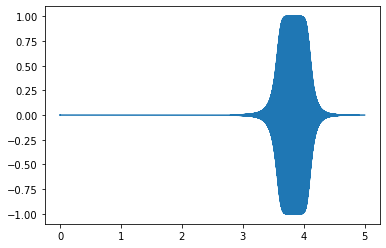

Type:            ndarray
String form:    
[ 0.00000000e+00  2.91762525e-06  2.28646780e-05 ... -9.65479003e-07
  7.42931563e-07 -4.58044352e-07]
Length:          220500
File:            c:\users\leadm\anaconda3\lib\site-packages\numpy\__init__.py
Docstring:       <no docstring>
Class docstring:
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instantiating an array.

For more information, refer to the `numpy` module and examine the
methods and attributes of an array.

Parameters
-

In [22]:
T = int(input("Ingrese el tiempo de reproducción:"))
fs = 44100
t = np.linspace(0., T, fs*T, False)
#Octava - G = 1.0/2.0 / 1/3 de Octava - G=1.0/6.0
G = 1.0/2.0
factor = np.power(2, G)
fs = 44100
#Pruebo con una frecuencia central
centerFrequency_Hz = 4000

#Calculo los extremos de la banda a partir de la frecuencia central
lowerCutoffFrequency_Hz=centerFrequency_Hz/factor;
upperCutoffFrequency_Hz=centerFrequency_Hz*factor;

#Extraemos los coeficientes del filtro 
sos = signal.iirfilter(4, [lowerCutoffFrequency_Hz,upperCutoffFrequency_Hz],
                            rs=60, btype='band', analog=False,
                            ftype='butter', fs=fs, output='sos') 

#w, h = signal.freqz(b,a)
#plt.plot(w, 20 * np.log10(abs(h)), 'b')

#aplicar el filtro al array en la variable audio
from scipy import signal
from scipy.io import wavfile
# Leyendo audio con scipy.io
audioFileName = "../sinesweep.wav"
# fs: Frequency sample y audiodata: Audio signal -> int16 (muy importante)
fs, audiodata = wavfile.read(audioFileName)
filt = signal.sosfilt(sos, audiodata)
plt.plot(t,filt)#signal.sosfilter(sos, audio)
audio2 = filt * (2**15 - 1) / np.max(np.abs(filt)) #Defino y reproduzco la función
audio2 = audio2.astype(np.int16)
play_obj = sa.play_buffer(audio2, 1, 2, 44100)
play_obj.wait_done()
filt?

In [33]:
def Filtro (fs,bandwidth,archivo):
    '''Filtro por octava o tercio de octava segun Norma 612600
       Parametros de entrada: 
        fs: Frecuencia de muestreo
        bandwith: Selector de octava o tercio de octava '''
    if bandwidth == 'octava': #ancho de banda de a octava 
        freqs = [31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000]
        G = 1.0/2.0
        filename = ["../Proyecto-python/audio/filtrado31,25Hz.wav","../Proyecto-python/audio/filtrado62,5Hz.wav","../Proyecto-python/audio/filtrado125Hz.wav","../Proyecto-python/audio/filtrado250Hz.wav","../Proyecto-python/audio/filtrado500Hz.wav",
                    "../Proyecto-python/audio/filtrado1000Hz.wav","../Proyecto-python/audio/filtrado2000Hz.wav","../Proyecto-python/audio/filtrado4000Hz.wav","../Proyecto-python/audio/filtrado8000Hz.wav"] 
    elif bandwidth == 'tercio': #ancho de banda de a tercio de octava 
        freqs = [19.69,24.80,31.25,39.37,49.61,62.50,78.75,99.21,125,157.5,198.4,250,
                 315,396.9,500,630,793.7,1000,1260,1587,2000,2520,3175,4000,5040,6350,8000]
        G = 1.0/6.0
    factor = np.power(2,G)
    for i in range(0,len(freqs)):
        fn = filename[i]  #Nombre del archivo que vaya cambiando segun frecuencia 
        frec_central = freqs[i] #Define las diferentes frecuencias centrales para el array freqs
        fcorte_inf = frec_central/factor #Define las diferentes frecuencias de corte inferior para el array freqs
        fcorte_sup = frec_central*factor #Define las diferentes frecuencias de corte superior para el array freqs
        sos = signal.iirfilter(12, [fcorte_inf,fcorte_sup],
                            rs=60, btype='band', analog=False,
                            ftype='butter', fs=fs, output='sos')
        filt = signal.sosfilt(sos, archivo)
        write(fn, fs, np.float32(filt)) #grabación 
        plt.plot(t,filt)
    return filt[0::len(freqs)]

Llamar a la función con alguna RI generada anteriormente.

<ipython-input-33-2ebd4920e52b>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  write(fn, fs, np.float32(filt)) #grabación
C:\Users\LeaDm\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-33-2ebd4920e52b>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  write(fn, fs, np.float32(filt)) #grabación
C:\Users\LeaDm\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-33-2ebd4920e52b>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  write(fn, fs, np.float32(filt)) #grabación
C:\Users\LeaDm\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary pa

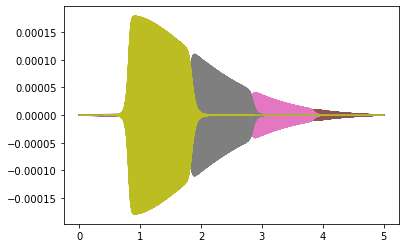

In [55]:
filtro = Filtro(fs,'octava',resp_impulso)

Graficar el dominio espectral del resultado en una banda, utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

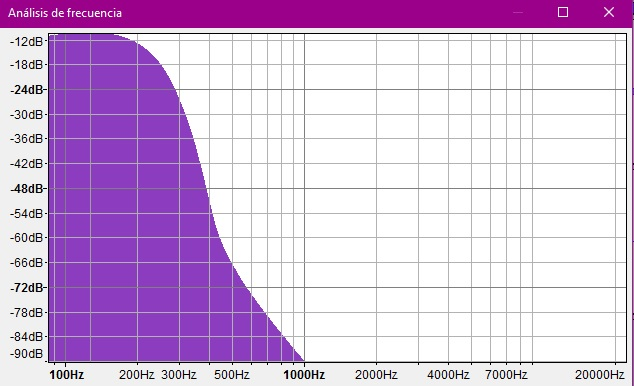

In [48]:
Image("../Proyecto-python/imagenes/125.jpg")

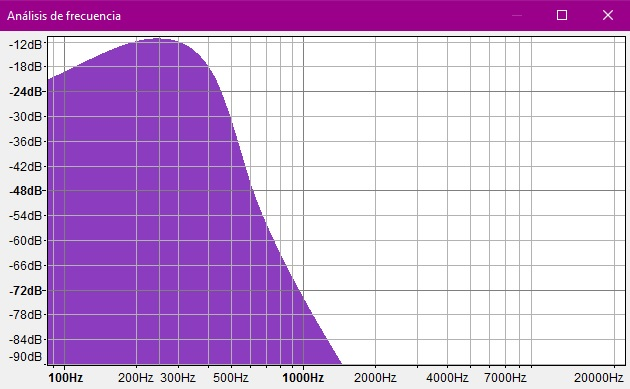

In [49]:
Image("../Proyecto-python/imagenes/250.jpg")

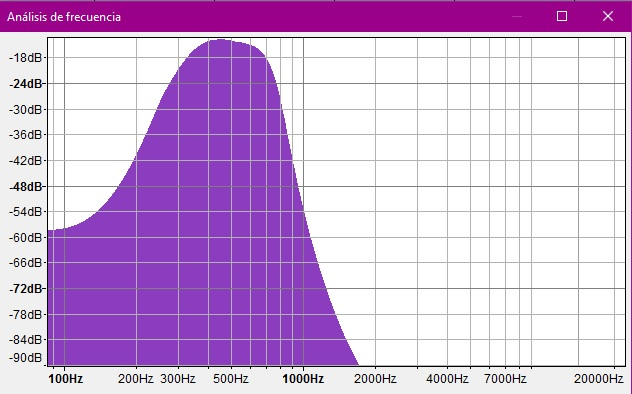

In [50]:
Image("../Proyecto-python/imagenes/500.jpg")

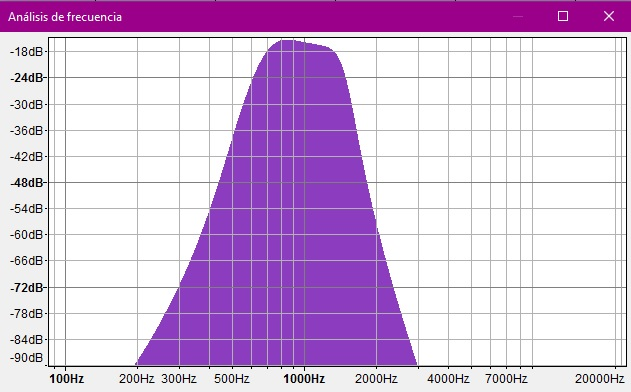

In [51]:
Image("../Proyecto-python/imagenes/1000.jpg")

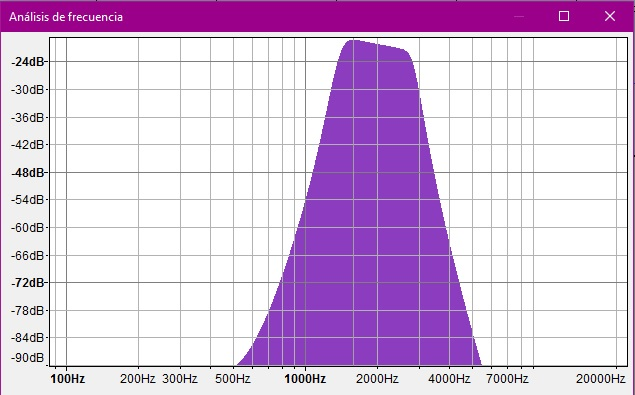

In [52]:
Image("../Proyecto-python/imagenes/2000.jpg")

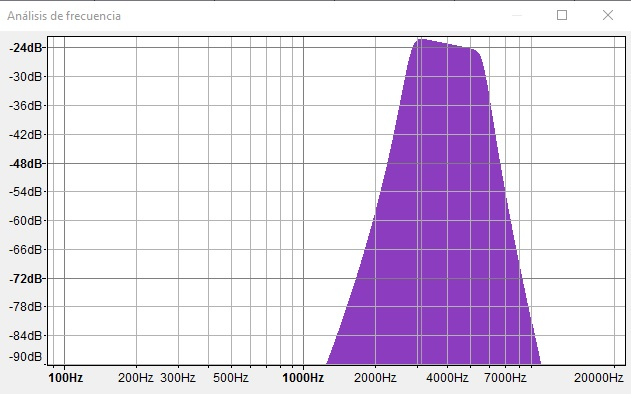

In [53]:
Image("../Proyecto-python/imagenes/4000.jpg")

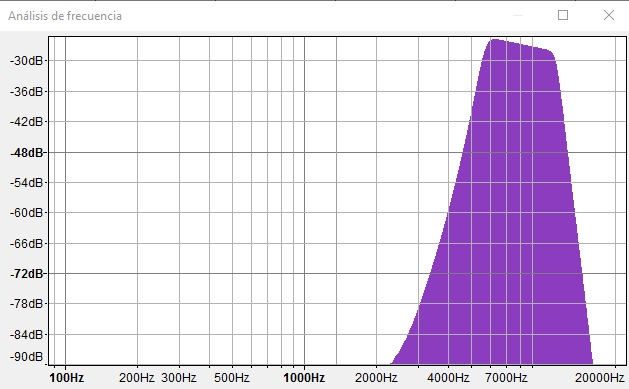

In [54]:
Image("../Proyecto-python/imagenes/8000.jpg")

¿El resultado es el esperado? ¿Cumple con los requerimientos de la normativa?

*completar*

## Función conversión a escala logarítmica normalizada
Para visualizar correctamente la señal es necesario realizar una función que convierta la respuesta al impulso en escala logarítmica, utilizando la siguiente expresión:

\begin{equation}
    R(t) = 20\log_{10}\frac{A(t)}{A(t)_{max}}
\tag{11}
\end{equation}

Donde $A(t)$ es la señal que deseamos transformar de escala. **Consigna:** crear una función que convierta a escala logarítmica la RI que ingresa y devuelva un array con la señal resultante.

In [40]:
def convlognormal(F):
    """
    Conversion a escala logaritmica normalizada
    Parámetros de entrada:
    F: Función a escalar
    Salida: Función normalizada y a escala logaritmica
    Utiliza librería Numpy.
    """
    ampmax=np.max(F)
    Fln=20*np.log10(F/ampmax)
    return Fln

Llamar a la función con alguna de las señales generadas anteriormente.

C:\Users\LeaDm\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


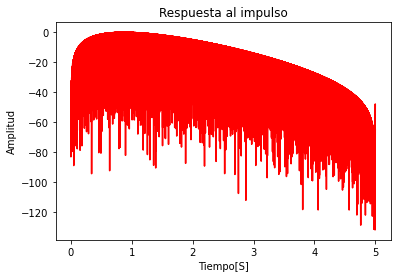

In [41]:
aa = convlognormal(resp_impulso)
graficador(aa,'Respuesta al impulso',T,'Tiempo[S]','Amplitud')

Visualizar la señal con la función creada en la primer entrega.

### Informe preliminar (opcional)
Realizar un informe preliminar en formato UNTREF para memorias cuatrimestrales (disponible en el Drive de la asignatura), utilizando la plataforma de dición de documentos [LaTeX](https://es.wikipedia.org/wiki/LaTeX). Respetar las siguientes consignas:
1. Mencionar los detalles en el diseño de los scripts(con ayuda de diagramas de flujo o pseudocódigo) sin agregar código propiamente dicho.
2. Describir el dataset seleccionado para probar el software.
3. El informe debe reflejar la arquitectura del software desarrollado y los avances en la producción del mismo. Los datos que se informan tienen que ser relevantes y garantizar la reproducibilidad de los mismos. No ahondar en muchos detalles teóricos y definiciones(hacer uso de referencias),hacer más bien foco en la producción del software, su evaluación y su validación.
4. El informe preliminar no debe exceder las 3 páginas. Respetar fecha de entrega.
5. Respetar los siguientes porcentajes de contenido por sección(también determinan los grados de importancia)

A modo ilustrastivo se muestra los porcentajes del contenido en los informes:

| Resumen | Introducción | Marco teórico | Desarrollo experimental | Resultados | Conclusiones |
| -- | -- | -- | -- | -- | --  |
| 5% | 10% | 10% | 25% | 30% | 20% |